## Initialization

Labels are of the form 

$$\lambda_i = (S_i, T_i, P_i, s_i, V^1_i, ..., V^{n}_i)$$


Where $n = |V|$

## Path storage

For the purpose of keeping the order in which items were collected, the labels were redeseigned for the ESPPRC algorithm and assume the following structure:

$$\lambda_i = (S_i, T_i, P_i, s_i, V^1_i, ..., V^{n}_i)$$


Where $n = |V|$ and $V^{j}_i$ is:

<ul>

<li> 0 if $j$ is a reachable vertice </li>

<li> $\infty$ if $j$ is an unreachable vertice </li>

<li> a number in $1, \dots, n$ that indicates the order in which this item was collected </li> (the origin is considered the first item)

</ul>

## Extend() function

In [1]:
"""
Functionality: extend a label from vertice i to vertice j (by certification in ESPPRC(), the extension will always be possible)

### Imput:
    lambda_i - matrix (2+r+n)x1 label to be extended from i;
    i - vertice that holds the current label;
    j - vertice that will receive a new label;
    T - matrix lx1 that constains the resources matrices;
    S - matrix nx1 that contains the survival value of each vertice;
    c - matrix nxndistance matrix;
    L - matrix nx1 that holds the upper limit of each resource.

### Output:
    lambda_j - matrix 1x(2+r+n)extended label.
"""
function Extend(lambda_i, i, j, S, T, L)
            
    viavel = true

    lambda_j =  copy(lambda_i)    
        
    lambda_j[1] = lambda_j[1] + S[i,j] # we add the objective function value and mark j as unreachable
    
    # uptading the order in which j was collected
    
    order = 1
    
    for k in lambda_j[(2+length(L)+1):end]
        if k > order && k != Inf
            order = k
            println
        end
    end
    
    lambda_j[2+length(L)+j] = order + 1
    
    for k in 1:length(L)
        lambda_j[k+1] = lambda_j[k+1] + T[k][i,j]
    end
    
    # uptading unreachable vertices from j now  
    
    for k in 1:n
        
        if lambda_j[2 + length(L) + k] == 0
            
            for g in 1:length(L)
                
                if (lambda_j[g+1] + T[g][j,k]) > L[g]
    
                    viavel = false
                    
                    break
                    
                end
                
            end
            
            if !viavel
                
                lambda_j[2 + length(L) + k] = Inf
                
            end

        end
        
        viavel = true
        
    end
    
    lambda_j[length(L)+2] = sum(1 for k in (length(L)+3):length(lambda_j) if lambda_j[k] > 0)   
        
    return lambda_j
end

Extend

## EFF() function

In [2]:
"""
Functionality: maintain the Lambda sets totally incomparable. Verifies which label can enter anda apply the domination rule to remove
labels from the set.

### Imput:
    Lambda - set of labels of a vertice;
    F - set of newly extended labels (that will possibly enter Lambda);
    bests - best objective function value (the entire label) obtained so far.

### Output:
    tmplambda - set Lambda possibly altered;
    changed - boolean that stores if Lambda was altered;
    bests - best objective function value (the entire label) obtained so far.
"""
function EFF(Lambda :: Set, F :: Set, bests)
        
    dominated = false
    
    changed = false
    
    tmplambda = copy(Lambda)
    
    if Lambda == Set([]) && F != Set([])
        
        changed = true 
        
        for l in F
            if l[1] > bests[1]
                bests = l
            end
        end
        
        return F, changed, bests
        
    else
        
        if F == Set([])
            
            changed = false
            
            return Lambda, changed, bests
            
        else
            
            for f in F
                for l in tmplambda 
                    
                    if l[1] >= f[1] && l != f
                        
                        dominated = true
                        
                        for k in 2:length(l)
                            
                            if l[k] > 0 && f[k] == 0
                                
                                dominated = false
                                
                                break
                                
                            end
                            
                        end
                        
                    end
                    
                    
                    if (l == f) || dominated
                        
                        break
                        
                    end
                    
                    
                end
                
                if !dominated && !(f in tmplambda)
                    
                    changed = true
                                        
                    for l in tmplambda
                        
                        if f[1] >= l[1] 
                            
                            dominated = true 
                            
                            for k in 2:length(l)
                                
                                if f[k] > 0 && l[k] == 0
                                    
                                    dominated = false
                                    
                                    break
                                    
                                end
                                
                            end
                            
                            if dominated
                            
                                tmplambda = setdiff(tmplambda, Set([l]))
                                
                            end
                            
                        end
                        
                    end
                    
                    tmplambda = union!(tmplambda, Set([f]))
                                        
                    if f[1] > bests[1]
                        
                        bests = f
                    
                    end
                    
                end
                
                dominated = false
            
            end
            
        end
        
    end
    
    return tmplambda, changed, bests
    
end

EFF

## ESPPRC function()

In [3]:
"""
Functionality: applies the label correcting algorithm on a totally connected graph for the ESPPRC.

### Imput:
    V - set of vertices of the graph;
    S - matrix nxn where each entry represents the objective value gained by traveling along each edge of the graph;
    T - matrix lx1 containig each resource matrix of the graph;
    L - matrix lx1 containing the upper limit for each resource;
    Lambda - matrix nx1 where each entry is the set of labels of the corresponding vertex;
    n - number of vertices of the graph;
    r - number of resources of the problem.

### Output:
    Lambda - matrix nx1 where each entry is the set of labels of the corresponding vertex;
    bests - optimal objective function value (the entire label)

"""
function ESPPRC(V, S, T, L, Lambda, n, r)
    
    bests = zeros(2+r+n)
    
    i = 1
    
    j = 1
    
    E = zeros(n)

    E[1] = 1

    F = Set([])
    
    changed = false
    
    while sum(E) != 0
        
        if E[i] != 0
                
            for k in 0:(n-2) 
                
                
                j = (i+k) % n + 1  
                                
                for l in Lambda[i]

                    if l[2+r+j] == 0 
                        
                        F = union(F, Set([Extend(l, i, j, S, T, L)])) 
                        
                    end
                    
                end
                
                Lambda[j], changed, bests = EFF(Lambda[j], F, bests)

                F = Set([])

                if changed
                    
                    E[j] = 1
                    
                end
                
            end
            
            E[i] = 0
            
        end
        
        i = i % n + 1
        
    end

    return Lambda, bests

end

ESPPRC

## Draw function

In [10]:
using Plots

In [14]:
"""
Functionality: draws the optimal path that collects all items from the optimal solution

#### Input:
    coord - coordinates of the items in the problem
    label - optimal label, containing th optimal path
    dimx, dimy - dimensions of the map in the x and y axis respectively
    r - number of resources in the problem

#### Output:
    Returns an image that contains the optimal path and all the items displayed in a cartesian plane.

"""
function draw(coord, label, dimx, dimy, r)
    
    n = length(coord)
    
    x = []

    for i in 1:length(coord)
        append!(x,coord[i][1])
    end

    y = []

    for i in 1:length(coord)
        append!(y,coord[i][2])
    end
    
    # drawing the items

    sct = scatter(x,y, title = "Optimal path", label = "", color = :blue3
        , gridcolor=:black, gridwidth=1, gridalpha =0.1
        , m = (:circle, 4, stroke(0)))
    
    annotate!(x, y.+0.1, text.(0:(length(x)-1), :bottom, 6))
    
    # drawing the map and the arrows
    
     plot!(sct 
    , xticks = ([-0.5:1:(dimx-0.5);])
    , x_foreground_color_text = :white
    , yticks = ([-0.5:1:(dimy-0.5);])
    , y_foreground_color_text = :white
    , axis = false)
    
    for i in 1:n 
        for j in 1:n 
            if (label[2+r+i] == label[2+r+j] - 1) && label[2+r+i] != Inf && label[2+r+j] != Inf
                plot!([coord[i][1], coord[j][1]], [coord[i][2], coord[j][2]]
                , color = :orange, arrow = :arrow, lw = 2, label = "")
            end
        end
    end
    
    display(sct)
end

draw

## Original HGP problem

In [16]:
S = [0; 15; 14; 10; 25; 15; 3; 30; 5; 7; 15; 10; 9; 2; 50; 5; 12; 10; 2; 2; 25]

P = [0; 9; 5; 3; 10; 10; 10; 15; 3; 3; 5; 5; 6; 1; 25; 7; 5; 4; 1; 2; 12]


n = 21

V = Set([i for i in 1:n])

r = 2 

Sobrev = zeros(n,n)

for i in 1:n
    for j in 1:n
        Sobrev[i,j] = S[j]
    end
end

function dist(x, y)
    d = abs(x[1] - y[1]) + abs(x[2] - y[2])
    return d
end



coord = [[0,0], [7,8], [2,12], [4,1], [14,12], [12,6], [13,3], [9,4], [10,10], [7,2], [3,4], [2,1], [1,7], [4,8]
        , [0,1], [10,14], [5,6], [14,13], [8,6], [6,12], [11,1]]

c = zeros(n,n)

for i in 1:length(coord)
    for j in 1:length(coord)
        c[i,j] = dist(coord[i],coord[j])
    end
end

Weight = zeros(n,n)

for i in 1:n
    for j in 1:n
        Weight[i,j] = P[j]
    end
end

T = [c, Weight]

L = [30, 30]

Lambda = Array{Any,1}(undef, n)

label_origin = zeros(n+r+2)

label_origin[r+2+1] = 1 

label_origin[r+2] = 1


for j in 1:n
    if (c[1,j] > L[1]) || (P[j] > L[2])
        label_origin[r+2+j] = Inf
    end
end

Lambda[1] = Set([label_origin])

for i in 2:n
    Lambda[i] = Set([])
end

lambda_j = 0

a = ESPPRC(V, Sobrev, T, L, Lambda, n, r)[2]


#solution: best survival value obtained = 77 collecting the itens 3, 10, 16, 8, 4 and 17 in this order

25-element Vector{Float64}:
 77.0
 30.0
 30.0
 21.0
  1.0
 Inf
 Inf
  2.0
  7.0
 Inf
 Inf
 Inf
  5.0
 Inf
  3.0
 Inf
 Inf
 Inf
 Inf
 Inf
  4.0
  6.0
 Inf
 Inf
 Inf

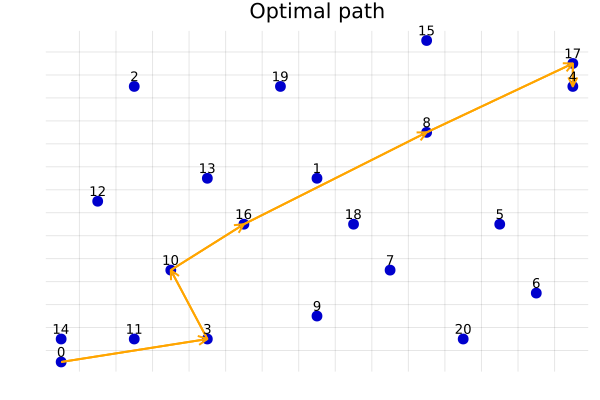

In [17]:
draw(coord, a, 15, 15, 2)

## Optimal set test

In [8]:
S = [0; 10; 25; 5; 15; 12; 10]

Sobrev = zeros(7,7)

n = 7

for i in 1:n
    for j in 1:n
        Sobrev[i,j] = S[j]
    end
end

P = [0; 3; 10; 3; 5; 5; 4]

V = Set([i for i in 1:n])

r = 2 

function dist(x, y)
    d = abs(x[1] - y[1]) + abs(x[2] - y[2])
    return d
end


coord = [[0,0], [4,1], [14,12], [10,10], [3,4], [5,6], [14,13]]

c = zeros(n,n)

for i in 1:length(coord)
    for j in 1:length(coord)
        c[i,j] = dist(coord[i],coord[j])
    end
end

Weight = zeros(n,n)

for i in 1:n
    for j in 1:n
        Weight[i,j] = P[j]
    end
end

display(Weight)


T = [c, Weight]

L = [30, 30]

Lambda = Array{Any,1}(undef, n)

label_origin = zeros(n+r+2)

label_origin[r+2+1] = 1

label_origin[r+2] = 1

for j in 1:n
    if c[1,j] > L[1] || P[j] > L[2]
        label_origin[r+2+j] = Inf
    end
end


Lambda[1] = Set([label_origin])

for i in 2:n
    Lambda[i] = Set([])
end


lambda_j = 0


bests = ESPPRC(V, Sobrev, T, L, Lambda, n, r)[2]
#solution: best survival value obtained = 77 collecting the items 3, 10, 16, 8, 4 and 17 in this order

7×7 Matrix{Float64}:
 0.0  3.0  10.0  3.0  5.0  5.0  4.0
 0.0  3.0  10.0  3.0  5.0  5.0  4.0
 0.0  3.0  10.0  3.0  5.0  5.0  4.0
 0.0  3.0  10.0  3.0  5.0  5.0  4.0
 0.0  3.0  10.0  3.0  5.0  5.0  4.0
 0.0  3.0  10.0  3.0  5.0  5.0  4.0
 0.0  3.0  10.0  3.0  5.0  5.0  4.0

11-element Vector{Float64}:
 77.0
 30.0
 30.0
  7.0
  1.0
  2.0
  7.0
  5.0
  3.0
  4.0
  6.0

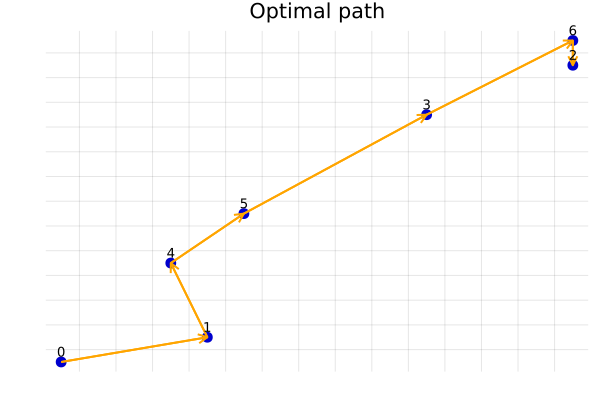

In [15]:
draw(coord, bests, 15, 15, 2)